# Identify generic genes and pathways

Studies have found that some genes are more likely to be differentially expressed even across a wide range of experimental designs. These generic genes and subsequent pathways are not necessarily specific to the biological process being studied but instead represent a more systematic change.

This notebook identifies generic genes and pathways and then evaluates if those identified are consistent with published findings.

**Steps to identify generic genes:**
1. Simulates N gene expression experiments using [ponyo](https://github.com/ajlee21/ponyo)
2. Perform DE analysis to get association statistics for each gene
3. For each gene, aggregate statsitics across all simulated experiments
4. Rank genes based on this aggregated statistic (i.e. log fold change, or p-value)


**Steps to identify generic gene sets (pathways):**
1. Using the same simulated experiments from above, perform GSEA analysis. This analysis will determine whether the genes contained in a gene set are clustered towards the beginning or the end of the ranked list of genes, where genes are ranked by log fold change, indicating a correlation with change in expression.
2. For each gene set (pathway), aggregate statistics across all simulated experiments
3. Rank gene sets based on this aggregated statistic

**Evaluation:**
* We want to compare the ranking of genes identified using the above method with the ranking found from [Crow et. al.](https://www.pnas.org/content/pnas/116/13/6491.full.pdf), which identified a set of genes as generic based on how frequently they were found to be DE across 600 experiments
* We want to compare the ranking of pathways identified using the above method with the ranking based on the [Powers et. al.](https://www.biorxiv.org/content/10.1101/259440v1.full.pdf) data, where ranking was determined based on the fraction of 442 experiments a pathway was found to be enriched
* This comparison will validate our method being used as a way to automatically identify generic genes and pathways.

In [1]:
%load_ext autoreload
%load_ext rpy2.ipython
%autoreload 2

import os
import sys
import pandas as pd
import numpy as np
import pickle
import glob
import scipy.stats as ss
from keras.models import load_model
from rpy2.robjects import pandas2ri
from ponyo import utils
from generic_expression_patterns_modules import process, stats, ranking

pandas2ri.activate()

np.random.seed(123)

Using TensorFlow backend.
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
# Read in config variables
base_dir = os.path.abspath(os.path.join(os.getcwd(), "../"))

config_filename = os.path.abspath(
    os.path.join(base_dir, "configs", "config_human_Crow.tsv")
)

params = utils.read_config(config_filename)

In [3]:
# Load params
local_dir = params["local_dir"]
dataset_name = params["dataset_name"]
NN_architecture = params["NN_architecture"]
num_runs = params["num_simulated"]
project_id = params["project_id"]
metadata_col_id = params["metadata_colname"]
mapped_template_filename = params["mapped_template_filename"]
processed_template_filename = params["processed_template_filename"]
normalized_compendium_filename = params["normalized_compendium_filename"]
scaler_filename = params["scaler_filename"]
col_to_rank_genes = params["rank_genes_by"]
col_to_rank_pathways = params["rank_pathways_by"]
statistic = params["gsea_statistic"]
logFC_name = params["DE_logFC_name"]
pvalue_name = params["DE_pvalue_name"]

# Load metadata file with grouping assignments for samples
sample_id_metadata_filename = os.path.join(
    base_dir, dataset_name, "data", "metadata", f"{project_id}_process_samples.tsv"
)

# Load metadata file with grouping assignments for samples
grp_metadata_filename = os.path.join(
    base_dir, dataset_name, "data", "metadata", f"{project_id}_groups.tsv"
)

# Load pickled file
with open(scaler_filename, "rb") as scaler_fh:
    scaler = pickle.load(scaler_fh)

# Percentile threshold to identify generic genes
percentile_threshold = 80.0

In [4]:
# Output files
gene_summary_filename = os.path.join(
    base_dir, dataset_name, f"generic_gene_summary_{project_id}.tsv"
)

pathway_summary_filename = os.path.join(
    base_dir, dataset_name, f"generic_pathway_summary_{project_id}.tsv"
)

## Need to customize code from ponyo

The current simulation-related function in ponyo, `get_sample_ids` assumes that the user is using one of two different metadata files (one associated with the pseudomonas compendium and another associated with recount2). The compendium dataset we are using here has a slightly different format for their metadata file.

Here we are temporarily writing our own function customized for this Powers et. al. dataset. But we will be updating ponyo to allow for different metadata files in the future. Issue in ponyo is [here](https://github.com/greenelab/ponyo/issues/18)

In [5]:
def get_sample_ids(experiment_id, dataset_name, sample_id_colname):
    """
    Returns sample ids (found in gene expression df) associated with
    a given list of experiment ids (found in the metadata)

    Arguments
    ----------
    experiment_ids_file: str
        File containing all cleaned experiment ids

    dataset_name: str
        Name for analysis directory. Either "Human" or "Pseudomonas"

    sample_id_colname: str
        Column header that contains sample id that maps expression data
        and metadata

    """
    # Read in metadata
    metadata = pd.read_csv(metadata_filename, header=0)
    metadata.set_index("Experiment id", inplace=True)

    selected_metadata = metadata.loc[experiment_id]
    sample_ids = list(selected_metadata[sample_id_colname])

    return sample_ids

In [6]:
def shift_template_experiment_with_metadatafile(
    normalized_data_file,
    selected_experiment_id,
    sample_id_colname,
    NN_architecture,
    dataset_name,
    scaler,
    local_dir,
    base_dir,
    run,
    metadata_filename,
):
    """
    Generate new simulated experiment using the selected_experiment_id as a template
    experiment using the same workflow as `simulate_by_latent_transform`

    This will return a file with a single simulated experiment following the workflow mentioned.
    This function can be run multiple times to generate multiple simulated experiments from a
    single selected_experiment_id.

    Arguments
    ----------
    normalized_data_file: str
        File containing normalized gene expression data

        ------------------------------| PA0001 | PA0002 |...
        05_PA14000-4-2_5-10-07_S2.CEL | 0.8533 | 0.7252 |...
        54375-4-05.CEL                | 0.7789 | 0.7678 |...
        ...                           | ...    | ...    |...

    selected_experiment_id: str
        Experiment id selected as template

    sample_id_colname: str
        Column header that contains sample id that maps expression data and metadata

    NN_architecture: str
        Name of neural network architecture to use.
        Format 'NN_<intermediate layer>_<latent layer>'

    dataset_name: str
        Name for analysis directory. Either "Human" or "Pseudomonas"

    scaler: minmax model
        Model used to transform data into a different range

    local_dir: str
        Parent directory on local machine to store intermediate results

    base_dir: str
        Root directory containing analysis subdirectories

    run: int
        Simulation run

    Returns
    --------
    simulated_data_file: str
        File containing simulated gene expression data

    """

    # Files
    NN_dir = os.path.join(base_dir, dataset_name, "models", NN_architecture)
    latent_dim = NN_architecture.split("_")[-1]

    model_encoder_file = glob.glob(os.path.join(NN_dir, "*_encoder_model.h5"))[0]

    weights_encoder_file = glob.glob(os.path.join(NN_dir, "*_encoder_weights.h5"))[0]

    model_decoder_file = glob.glob(os.path.join(NN_dir, "*_decoder_model.h5"))[0]

    weights_decoder_file = glob.glob(os.path.join(NN_dir, "*_decoder_weights.h5"))[0]

    # Load saved models
    loaded_model = load_model(model_encoder_file, compile=False)
    loaded_decode_model = load_model(model_decoder_file, compile=False)

    loaded_model.load_weights(weights_encoder_file)
    loaded_decode_model.load_weights(weights_decoder_file)

    # Read data
    normalized_data = pd.read_csv(normalized_data_file, header=0, sep="\t", index_col=0)

    # Get corresponding sample ids
    sample_ids = get_sample_ids(
        selected_experiment_id, metadata_filename, sample_id_colname
    )

    # Gene expression data for selected samples
    selected_data_df = normalized_data.loc[sample_ids]

    # Encode selected experiment into latent space
    data_encoded = loaded_model.predict_on_batch(selected_data_df)
    data_encoded_df = pd.DataFrame(data_encoded, index=selected_data_df.index)

    # Get centroid of original data
    centroid = data_encoded_df.mean(axis=0)

    # Add individual vectors(centroid, sample point) to new_centroid

    # Encode original gene expression data into latent space
    data_encoded_all = loaded_model.predict_on_batch(normalized_data)
    data_encoded_all_df = pd.DataFrame(data_encoded_all, index=normalized_data.index)

    data_encoded_all_df.head()

    # Find a new location in the latent space by sampling from the latent space
    encoded_means = data_encoded_all_df.mean(axis=0)
    encoded_stds = data_encoded_all_df.std(axis=0)

    latent_dim = int(latent_dim)
    new_centroid = np.zeros(latent_dim)

    for j in range(latent_dim):
        new_centroid[j] = np.random.normal(encoded_means[j], encoded_stds[j])

    shift_vec_df = new_centroid - centroid
    # print(shift_vec_df)

    simulated_data_encoded_df = data_encoded_df.apply(
        lambda x: x + shift_vec_df, axis=1
    )

    # Decode simulated data into raw gene space
    simulated_data_decoded = loaded_decode_model.predict_on_batch(
        simulated_data_encoded_df
    )

    simulated_data_decoded_df = pd.DataFrame(
        simulated_data_decoded,
        index=simulated_data_encoded_df.index,
        columns=selected_data_df.columns,
    )

    # Un-normalize the data in order to run DE analysis downstream
    simulated_data_scaled = scaler.inverse_transform(simulated_data_decoded_df)

    simulated_data_scaled_df = pd.DataFrame(
        simulated_data_scaled,
        columns=simulated_data_decoded_df.columns,
        index=simulated_data_decoded_df.index,
    )

    # Save template data for visualization validation
    test_file = os.path.join(
        local_dir,
        "pseudo_experiment",
        "template_normalized_data_" + selected_experiment_id + "_test.txt",
    )

    selected_data_df.to_csv(test_file, float_format="%.3f", sep="\t")

    # Save
    out_file = os.path.join(
        local_dir,
        "pseudo_experiment",
        "selected_simulated_data_" + selected_experiment_id + "_" + str(run) + ".txt",
    )

    simulated_data_scaled_df.to_csv(out_file, float_format="%.3f", sep="\t")

    out_encoded_file = os.path.join(
        local_dir,
        "pseudo_experiment",
        f"selected_simulated_encoded_data_{selected_experiment_id}_{run}.txt",
    )

    simulated_data_encoded_df.to_csv(out_encoded_file, float_format="%.3f", sep="\t")

### Simulate experiments using selected template experiment

Workflow:
1. Get the gene expression data for the selected template experiment
2. Encode this experiment into a latent space using the trained VAE model
3. Linearly shift the encoded template experiment in the latent space
4. Decode the samples. This results in a new experiment
5. Repeat steps 1-4 to get multiple simulated experiments

In [7]:
# Load metadata file with experiment to sample mapping
metadata_filename = os.path.join(
    base_dir, dataset_name, "data", "metadata", "experiment_sample_annotations.csv"
)

In [8]:
# Simulate multiple experiments
# This step creates the following files in "<local_dir>/pseudo_experiment/" directory:
#   - selected_simulated_data_SRP012656_<n>.txt
#   - selected_simulated_encoded_data_SRP012656_<n>.txt
#   - template_normalized_data_SRP012656_test.txt
# in which "<n>" is an integer in the range of [0, num_runs-1]
os.makedirs(os.path.join(local_dir, "pseudo_experiment"), exist_ok=True)
for run_id in range(num_runs):
    shift_template_experiment_with_metadatafile(
        normalized_compendium_filename,
        project_id,
        metadata_col_id,
        NN_architecture,
        dataset_name,
        scaler,
        local_dir,
        base_dir,
        run_id,
        metadata_filename,
    )

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



## Reverse transformation

In [9]:
# Undo log transformation...
# CHeck that template is also in log or unlogged form
# Or log transform mapped_template instead
mapped_template = pd.read_csv(mapped_template_filename, sep="\t", index_col=0, header=0)

mapped_template_transform = (
    np.log10(mapped_template).replace(-np.inf, 0.0).replace(np.nan, 0.0)
)

mapped_template_transform.to_csv(mapped_template_filename, sep="\t")

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys


### Process template and simulated experiments

* Remove samples not required for comparison. Since this experiment contains multiple conditions (i.e. estradiol vs EtOH at 12, 24, and 48 hrs are each considered a different comparison) being tested, we will only include those samples within the same condition.
* Make sure ordering of samples matches metadata for proper comparison

In [10]:
if not os.path.exists(sample_id_metadata_filename):
    sample_id_metadata_filename = None

stats.process_samples_for_limma(
    mapped_template_filename,
    grp_metadata_filename,
    processed_template_filename,
    sample_id_metadata_filename,
)

for i in range(num_runs):
    simulated_filename = os.path.join(
        local_dir, "pseudo_experiment", f"selected_simulated_data_{project_id}_{i}.txt"
    )
    out_simulated_filename = os.path.join(
        local_dir,
        "pseudo_experiment",
        f"selected_simulated_data_{project_id}_{i}_processed.txt",
    )
    stats.process_samples_for_limma(
        simulated_filename,
        grp_metadata_filename,
        out_simulated_filename,
        sample_id_metadata_filename,
    )

sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly


### Differential expression analysis

The gene expression dataset is array-based so we will use Limma in this case

In [11]:
# Create subdirectory: "<local_dir>/DE_stats/"
os.makedirs(os.path.join(local_dir, "DE_stats"), exist_ok=True)

In [12]:
%%R -i grp_metadata_filename -i project_id -i processed_template_filename -i local_dir -i base_dir

source(paste0(base_dir, '/generic_expression_patterns_modules/DE_analysis.R'))

# File created: "<local_dir>/DE_stats/DE_stats_template_data_SRP012656_real.txt"
get_DE_stats_limma(grp_metadata_filename,
                   project_id,
                   processed_template_filename,
                   "template",
                   local_dir,
                   "real")

R[write to console]: Loading required package: S4Vectors

R[write to console]: Loading required package: stats4

R[write to console]: Loading required package: BiocGenerics

R[write to console]: Loading required package: parallel

R[write to console]: 
Attaching package: ‘BiocGenerics’


R[write to console]: The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


R[write to console]: The following object is masked from ‘package:limma’:

    plotMA


R[write to console]: The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


R[write to console]: The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply

[1] 0


In [13]:
# Check number of DEGs
template_DE_stats_filename = os.path.join(
    local_dir, "DE_stats", f"DE_stats_template_data_{project_id}_real.txt"
)

template_DE_stats = pd.read_csv(
    template_DE_stats_filename, sep="\t", header=0, index_col=0
)

selected = template_DE_stats[
    (template_DE_stats["adj.P.Val"] < 0.05) & (abs(template_DE_stats["logFC"]) > 1)
]
print(selected.shape)

(2, 6)


In [14]:
%%R -i grp_metadata_filename -i project_id -i base_dir -i local_dir -i num_runs

source(paste0(base_dir, '/generic_expression_patterns_modules/DE_analysis.R'))

# Files created: "<local_dir>/DE_stats/DE_stats_simulated_data_SRP012656_<n>.txt"
for (i in 0:(num_runs-1)){
    simulated_data_filename <- paste(local_dir,
                                     "pseudo_experiment/selected_simulated_data_",
                                     project_id,
                                     "_",
                                     i,
                                     ".txt",
                                     sep = "")

    get_DE_stats_limma(grp_metadata_filename,
                       project_id,
                       simulated_data_filename,
                       "simulated",
                       local_dir,
                       i)
}

### Rank genes

In [15]:
analysis_type = "DE"
template_DE_stats, simulated_DE_summary_stats = ranking.process_and_rank_genes_pathways(
    template_DE_stats_filename,
    local_dir,
    num_runs,
    project_id,
    analysis_type,
    col_to_rank_genes,
    logFC_name,
    pvalue_name,
)

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


### Gene summary table

In [16]:
summary_gene_ranks = ranking.generate_summary_table(
    template_DE_stats_filename,
    template_DE_stats,
    simulated_DE_summary_stats,
    col_to_rank_genes,
    local_dir,
    "gene",
    params,
)

summary_gene_ranks.head()

,Gene ID,Adj P-value (Real),Rank (Real),abs(logFC) (Real),logFC (Real),Median adj p-value (simulated),Rank (simulated),Percentile (simulated),Percent DE (simulated),Mean abs(logFC) (simulated),Std deviation (simulated),Number of experiments (simulated),Z score
CTDSP1,CTDSP1,0.084956,7130.0,1.606481,1.606481,0.028704,4506.0,63.192594,0.0,0.003758,0.002353,25,681.210668
HPRT1,HPRT1,0.106641,7129.0,1.407730,-1.407730,0.000814,5581.0,78.271847,0.0,0.006104,0.003798,25,369.021174
SUZ12,SUZ12,0.110575,7128.0,1.376910,-1.376910,0.191946,2545.5,35.692243,0.0,0.003389,0.003898,25,352.365043
MRPL47,MRPL47,0.112816,7127.0,1.233399,-1.233399,0.021224,3911.5,54.853416,0.0,0.003900,0.003378,25,363.978790
GNPNAT1,GNPNAT1,0.431884,7126.0,1.216652,-1.216652,0.187207,4616.0,64.735587,0.0,0.004273,0.003566,25,339.969867


In [17]:
# Check if there is an NaN values, there should not be
summary_gene_ranks.isna().any()

Gene ID                              False
Adj P-value (Real)                   False
Rank (Real)                          False
abs(logFC) (Real)                    False
logFC (Real)                         False
Median adj p-value (simulated)       False
Rank (simulated)                     False
Percentile (simulated)               False
Percent DE (simulated)               False
Mean abs(logFC) (simulated)          False
Std deviation (simulated)            False
Number of experiments (simulated)    False
Z score                              False
dtype: bool

In [18]:
# Create `gene_summary_fielname`
summary_gene_ranks.to_csv(gene_summary_filename, sep="\t")

### Compare gene ranking
Studies have found that some genes are more likely to be differentially expressed even across a wide range of experimental designs. These *generic genes* are not necessarily specific to the biological process being studied but instead represent a more systematic change.

We want to compare the ability to detect these generic genes using our method vs those found by [Crow et. al. publication](https://www.pnas.org/content/pnas/116/13/6491.full.pdf). Their genes are ranked 0 = not commonly DE; 1 = commonly DE. Genes were ranked by the number differentially expressed gene sets a gene appeared in across 600 experiments.

r = 0.5913626553102406
p = 0.0
ci_low = 0.5746856575643265
ci_high = 0.6075444014303418


/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['Verdana'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


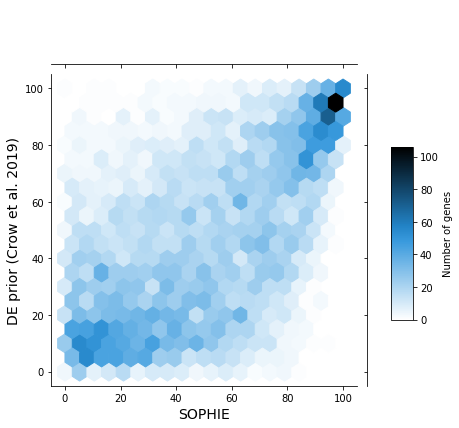

In [19]:
# Get generic genes identified by Crow et. al.
DE_prior_filename = params["reference_gene_filename"]
ref_gene_col = params["reference_gene_name_col"]
ref_rank_col = params["reference_rank_col"]

figure_filename = f"gene_ranking_{col_to_rank_genes}.svg"

corr, shared_ranking = ranking.compare_gene_ranking(
    summary_gene_ranks, DE_prior_filename, ref_gene_col, ref_rank_col, figure_filename
)

Hypergeometric test:

Given $N$ number of genes with $K$ common genes in Crow et al. SOPHIE identifies $n$ genes as being common. What is the probability that $k$ of the genes identified by SOPHIE are also common in Crow et al.? What is the probability of drawing $k$ or more concordant genes?

This was a way for us to quantify the correlation between SOPHIE and Crow et al common findings, since the correlation coefficient wasn't very convincing since we're considering all genes in addition to the common ones

In [20]:
num_Crow_genes = shared_ranking.shape[0]
num_generic_Crow_genes = shared_ranking.query(f"{ref_rank_col}>=80.0").shape[0]
num_generic_SOPHIE_genes = shared_ranking[
    shared_ranking["Percentile (simulated)"] >= percentile_threshold
].shape[0]
num_concordant_generic_genes = shared_ranking[
    (shared_ranking[ref_rank_col] >= percentile_threshold)
    & (shared_ranking["Percentile (simulated)"] >= percentile_threshold)
].shape[0]

In [21]:
print(num_Crow_genes)
print(num_generic_Crow_genes)
print(num_generic_SOPHIE_genes)
print(num_concordant_generic_genes)

6834
1213
1397
789


In [22]:
p = ss.hypergeom.sf(
    num_concordant_generic_genes,
    num_Crow_genes,
    num_generic_Crow_genes,
    num_generic_SOPHIE_genes,
)
print(p)

0.0


**Takeaway:**
* Here we are comparing gene percentiles obtained from SOPHIE trained on Crow et al. vs gene percentiles obtained from manual curation using Crow et al. There is a high correlation between gene percentiles, validating the SOPHIE approach.

### GSEA
**Goal:** To detect modest but coordinated changes in prespecified sets of related genes (i.e. those genes in the same pathway or share the same GO term).

1. Rank all genes using DE association statistics.
2. An enrichment score (ES) is defined as the maximum distance from the middle of the ranked list. Thus, the enrichment score indicates whether the genes contained in a gene set are clustered towards the beginning or the end of the ranked list (indicating a correlation with change in expression).
3. Estimate the statistical significance of the ES by a phenotypic-based permutation test in order to produce a null distribution for the ES (i.e. scores based on permuted phenotype)

In [23]:
# Create "<local_dir>/GSEA_stats/" subdirectory
os.makedirs(os.path.join(local_dir, "GSA_stats"), exist_ok=True)

In [24]:
# Load pathway data
hallmark_DB_filename = params["pathway_DB_filename"]

In [25]:
%%R -i base_dir -i template_DE_stats_filename -i hallmark_DB_filename -i statistic -i local_dir -o template_enriched_pathways

source(paste0(base_dir, '/generic_expression_patterns_modules/GSEA_analysis.R'))

out_filename <- paste(local_dir,
                     "GSA_stats/GSEA_stats_template_data_",
                     project_id,
                     "_real.txt",
                     sep = "")

template_enriched_pathways <- find_enriched_pathways(template_DE_stats_filename, hallmark_DB_filename, statistic)
template_enriched_pathways <- as.data.frame(template_enriched_pathways[1:7])

write.table(template_enriched_pathways, file = out_filename, row.names = F, sep = "\t")

R[write to console]: Loading required package: Rcpp



In [26]:
print(template_enriched_pathways.shape)
template_enriched_pathways[template_enriched_pathways["padj"] < 0.05].sort_values(
    by="padj"
)

(50, 7)


,pathway,pval,padj,ES,NES,nMoreExtreme,size


**Quick check:** Looks like enriched pathways are consistent with estradiol being estrogen hormone treatment.

In [27]:
%%R -i project_id -i local_dir -i hallmark_DB_filename -i num_runs -i statistic -i base_dir

source(paste0(base_dir, '/generic_expression_patterns_modules/GSEA_analysis.R'))

# New files created: "<local_dir>/GSEA_stats/GSEA_stats_simulated_data_<project_id>_<n>.txt"
for (i in 0:(num_runs-1)) {
    simulated_DE_stats_filename <- paste(local_dir,
                                     "DE_stats/DE_stats_simulated_data_",
                                     project_id,
                                     "_",
                                     i,
                                     ".txt",
                                     sep = "")

    out_filename <- paste(local_dir,
                     "GSA_stats/GSEA_stats_simulated_data_",
                     project_id,
                     "_",
                     i,
                     ".txt",
                     sep = "")

    enriched_pathways <- find_enriched_pathways(simulated_DE_stats_filename, hallmark_DB_filename, statistic)

    write.table(as.data.frame(enriched_pathways[1:7]), file = out_filename, row.names = F, sep = "\t")
}

### Rank pathways

In [28]:
analysis_type = "GSA"
template_GSEA_stats_filename = os.path.join(
    local_dir, "GSA_stats", f"GSEA_stats_template_data_{project_id}_real.txt"
)
(
    template_GSEA_stats,
    simulated_GSEA_summary_stats,
) = ranking.process_and_rank_genes_pathways(
    template_GSEA_stats_filename,
    local_dir,
    num_runs,
    project_id,
    analysis_type,
    col_to_rank_pathways,
    logFC_name,
    pvalue_name,
    "GSEA",
)

### Pathway summary table

In [29]:
# Create intermediate file: "<local_dir>/gene_summary_table_<col_to_rank_pathways>.tsv"
summary_pathway_ranks = ranking.generate_summary_table(
    template_GSEA_stats_filename,
    template_GSEA_stats,
    simulated_GSEA_summary_stats,
    col_to_rank_pathways,
    local_dir,
    "pathway",
    params,
)

summary_pathway_ranks.sort_values(by="Rank (simulated)", ascending=False).head(10)

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


,Pathway ID,Adj P-value (Real),Rank (Real),padj (Real),Median adj p-value (simulated),Rank (simulated),Percentile (simulated),Mean padj (simulated),Std deviation (simulated),Number of experiments (simulated),Z score
pathway,,,,,,,,,,,
HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION,HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION,0.865211,29.0,0.865211,0.000816,48.0,100.000000,0.001753,0.003135,25,275.426791
HALLMARK_KRAS_SIGNALING_UP,HALLMARK_KRAS_SIGNALING_UP,0.865211,29.0,0.865211,0.000816,48.0,100.000000,0.019597,0.038963,25,21.702966
HALLMARK_COMPLEMENT,HALLMARK_COMPLEMENT,0.865211,29.0,0.865211,0.000816,48.0,100.000000,0.037077,0.085878,25,9.643168
HALLMARK_INFLAMMATORY_RESPONSE,HALLMARK_INFLAMMATORY_RESPONSE,0.865211,29.0,0.865211,0.000816,48.0,100.000000,0.093793,0.234613,25,3.288048
HALLMARK_COAGULATION,HALLMARK_COAGULATION,0.865211,29.0,0.865211,0.000816,48.0,100.000000,0.001565,0.002173,25,397.466063
HALLMARK_INTERFERON_GAMMA_RESPONSE,HALLMARK_INTERFERON_GAMMA_RESPONSE,0.908099,1.0,0.908099,0.001184,44.5,92.553191,0.108079,0.249879,25,3.201633
HALLMARK_ALLOGRAFT_REJECTION,HALLMARK_ALLOGRAFT_REJECTION,0.865211,29.0,0.865211,0.001184,44.5,92.553191,0.069547,0.154376,25,5.154057
HALLMARK_IL6_JAK_STAT3_SIGNALING,HALLMARK_IL6_JAK_STAT3_SIGNALING,0.865211,29.0,0.865211,0.003221,43.0,89.361702,0.163406,0.299810,25,2.340835
HALLMARK_MYOGENESIS,HALLMARK_MYOGENESIS,0.865211,29.0,0.865211,0.003433,42.0,87.234043,0.034921,0.083674,25,9.922961


In [30]:
# Create `pathway_summary_filename`
summary_pathway_ranks.to_csv(pathway_summary_filename, sep="\t")

### Compare pathway ranking

Studies have found that there are some pathways (gene sets) that are more likely to be significantly enriched in DEGs across a wide range of experimental designs. These generic pathways are not necessarily specific to the biological process being studied but instead represents a more systematic change.

We want to compare the ability to detect these generic pathways using our method vs those found by [Powers et. al.](https://www.biorxiv.org/content/10.1101/259440v1.full.pdf) publication.  We will use the `Hallmarks_qvalues_GSEAPreranked.csv` file from https://www.synapse.org/#!Synapse:syn11806255 as a reference. The file contains the q-value (adjusted p-value) for the test: given the enrichment score (ES) of the experiment is significant compared to the null distribution of enrichment scores, where the null set is generated from permuted gene sets. For each gene set (pathway) they calculate the q-value using this test.


To get a `reference ranking`, we calculate the fraction of experiments that a given pathway was significant (q-value <0.05) and use this rank pathways. `Our ranking` is to rank pathways based on the median q-value across the simulated experiments. We can then compare `our ranking` versus the `reference ranking.`

In [31]:
# Load Powers et. al. results file
powers_rank_filename = os.path.join(
    base_dir, dataset_name, "data", "metadata", "Hallmarks_qvalues_GSEAPreranked.csv"
)

In [33]:
# Read Powers et. al. data
# This file contains qvalue results for hallmark pathways across ~400 experiments
powers_rank_df = pd.read_csv(powers_rank_filename, header=0, index_col=0)
powers_rank_df.drop(["Category"], axis=1, inplace=True)
print(powers_rank_df.shape)
powers_rank_df.head()

(50, 443)


,GSE10281_DEG_Expt1_Control_vs_Group1_qval,GSE10299_DEG_Expt1_Control_vs_Group1_qval,GSE10299_DEG_Expt1_Control_vs_Group2_qval,GSE10311_DEG_Expt1_Control_vs_Group1_qval,GSE10410_DEG_Expt1_Control_vs_Group1_qval,GSE10410_DEG_Expt1_Control_vs_Group2_qval,GSE10592_DEG_Expt1_Control_vs_Group1_qval,GSE10592_DEG_Expt2_Control_vs_Group1_qval,GSE11142_DEG_Expt1_Control_vs_Group1_qval,GSE11285_DEG_Expt1_Control_vs_Group1_qval,...,GSE79761_DEG_Expt1_Control_vs_Group2_qval,GSE79761_DEG_Expt1_Control_vs_Group3_qval,GSE83120_DEG_Expt1_Control_vs_Group1_qval,GSE83491_DEG_Expt1_Control_vs_Group1_qval,GSE83491_DEG_Expt2_Control_vs_Group1_qval,GSE8588_DEG_Expt1_Control_vs_Group1_qval,GSE8588_DEG_Expt1_Control_vs_Group2_qval,GSE8597_DEG_Expt1_Control_vs_Group1_qval,GSE8658_DEG_Expt1_Control_vs_Group1_qval,GSE9988_DEG_Expt1_Control_vs_Group1_qval
Term,,,,,,,,,,,,,,,,,,,,,
HALLMARK_APICAL_JUNCTION,0.010497,0.994108,0.045536,0.498151,0.538082,0.429205,0.355439,0.236627,0.767614,0.858065,...,0.637333,0.019621,0.086923,0.453315,0.730539,0.005366,0.863592,0.102867,0.639821,0.465678
HALLMARK_APICAL_SURFACE,0.443835,0.598008,0.181818,0.407927,0.130422,0.588732,0.192183,0.003519,1.000000,0.809823,...,0.260565,0.018686,0.691567,0.588169,1.000000,0.172392,0.657082,0.008060,0.618102,0.229456
HALLMARK_PEROXISOME,0.110897,0.988705,0.118807,0.094770,0.004288,0.115514,0.172297,0.035202,0.682219,0.393990,...,0.447485,0.380294,0.058549,0.110354,0.215365,0.006037,0.034110,0.331770,0.005224,1.000000
HALLMARK_ADIPOGENESIS,0.011177,0.461255,0.171288,0.020412,0.010720,0.000000,0.191663,0.846586,0.895637,0.056589,...,0.604963,0.805532,0.054415,0.022888,0.000000,0.735339,0.636778,0.649874,0.000000,0.435622
HALLMARK_ANGIOGENESIS,0.006014,0.380219,0.663985,0.992954,0.175682,0.010256,0.004750,0.015640,1.000000,0.402218,...,0.007489,0.023545,0.965871,0.035213,0.646400,0.004025,0.209530,0.007165,0.181685,0.108067


In [34]:
# Count the number of experiments where a given pathway was found to be enriched (qvalue < 0.05)
total_num_experiments = powers_rank_df.shape[1]
frac_enriched_pathways = (powers_rank_df < 0.05).sum(axis=1) / total_num_experiments

# Rank pathways from 0-50, 50 indicating that the pathways was frequently enriched
pathway_ranks = frac_enriched_pathways.rank()

powers_rank_stats_df = pd.DataFrame(
    data={
        "Fraction enriched": frac_enriched_pathways.values,
        "Powers Rank": pathway_ranks.values,
    },
    index=powers_rank_df.index,
)
powers_rank_stats_df.sort_values(by="Powers Rank", ascending=False).head()

,Fraction enriched,Powers Rank
Term,,
HALLMARK_TNFA_SIGNALING_VIA_NFKB,0.668172,50.0
HALLMARK_E2F_TARGETS,0.645598,49.0
HALLMARK_G2M_CHECKPOINT,0.586907,48.0
HALLMARK_MITOTIC_SPINDLE,0.539503,47.0
HALLMARK_MYC_TARGETS_V1,0.528217,46.0


In [35]:
# Save reference file for input into comparison
powers_rank_processed_filename = os.path.join(
    base_dir,
    dataset_name,
    "data",
    "metadata",
    "Hallmarks_qvalues_GSEAPreranked_processed.tsv",
)

powers_rank_stats_df.to_csv(
    powers_rank_processed_filename,
    sep="\t",
)

r = 0.40314288763144646
p = 0.0036978859484643597
ci_low = 0.18708669905391231
ci_high = 0.579217691396006
{'r': 0.40314288763144646, 'p': 0.0036978859484643597, 'ci_low': 0.18708669905391231, 'ci_high': 0.579217691396006}


{'r': 0.40314288763144646,
 'p': 0.0036978859484643597,
 'ci_low': 0.18708669905391231,
 'ci_high': 0.579217691396006}

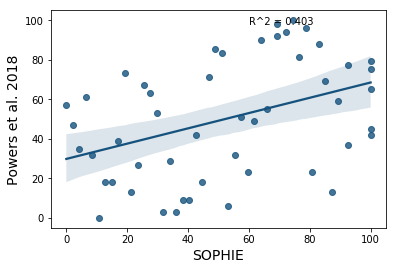

In [36]:
figure_filename = f"pathway_ranking_{col_to_rank_pathways}.svg"

ranking.compare_pathway_ranking(
    summary_pathway_ranks, powers_rank_processed_filename, figure_filename
)

**Takeaway:**
* Our method ranked pathways using median adjusted p-value score across simulated experiments.
* Powers et. al. ranked pathways based on the fraction of experiments they had adjusted p-value < 0.05.
* Here, we compare pathway ranks obtained from SOPHIE trained on Crow et al. vs pathway ranking based on manual curation using Powers et. al datasets.
* Despite the two datasets have a different context, we still see a good correlation.